In [1]:
import pandas as pd 
import numpy as np
import pymc3 as pm
from __future__ import print_function
from sklearn import metrics
from scipy import linalg, optimize, sparse
from sklearn.metrics import confusion_matrix, accuracy_score
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# PREPROCESSING
df  = pd.read_csv("results_259_Descriptive_norms-replication-XPLab-2021_group_7.csv")

# search all participants with valid responses and save their id
# vdf = valid dataframe, dataframe of valid participants
vdf = df.loc[df['response'] == 'Participants chose which action they preferred']
vdf = vdf[['submission_id']]

# vidf = valid identity dataframe; dataframe only with ID's of valid participants
vidf = pd.DataFrame()
for n in vdf['submission_id']:
    vidf = vidf.append(df.loc[df['submission_id'] == n])
    
# sdf = shortened dataframe
# every participants has 7 rows, the response value is in the third, so starting from the third row, get only every seventh
sdf = vidf.iloc[3::7, :]

# dataframe for ingroup agree
iadf = vidf.iloc[5::7, :]
#iadf = iadf['response']

# dataframe for outgroup disagree
oddf = vidf.iloc[6::7, :]
#oddf = oddf['response']

# dataframe with only analytically important values
newdf = sdf[['both_norms_shown','ingroup_descriptive_norm','response']]
newdf['outgroup_descriptive_norm'] = newdf['ingroup_descriptive_norm'] * -1

# add ingroup agree in binary value, 1 if >= 5, else 0
newdf['ingroup_agree'] = iadf['response'].values
newdf['ingroup_agree'] = pd.to_numeric(newdf['ingroup_agree'])
newdf['ingroup_agree'] = np.where((newdf['ingroup_agree'] >= 5), 1,newdf['ingroup_agree'])
newdf['ingroup_agree'] = np.where((newdf['ingroup_agree'] < 5), 0,newdf['ingroup_agree'])

# add outgroup disagree in binary value, 1 if >= 5, else 0
newdf['outgroup_disagree'] = oddf['response'].values
newdf['outgroup_disagree'] = pd.to_numeric(newdf['outgroup_disagree'])
newdf['outgroup_disagree'] = np.where((newdf['outgroup_disagree'] <= 3), 1,newdf['outgroup_disagree'])
newdf['outgroup_disagree'] = np.where((newdf['outgroup_disagree'] > 0), 0,newdf['outgroup_disagree'])
print(newdf)

In [ ]:
# ANALYSIS

# odds of responding higher
#𝑙𝑜𝑔𝑒(odds of responding higher)=𝑏𝑖𝑛𝐼+𝑏𝑏𝑜𝑡ℎ𝐵+𝑏𝑜𝑢𝑡𝐼×𝐵
#Here, I represents the INGROUP NORM condition (and the corresponding direction of the outgroup norm),
#B represents BOTH NORMS SHOWN and I x B represents the OUTGROUP NORM, 
#while bin, bboth and bout are parameters representing the effects of changing these conditions.
# PRIORS MISSING!
newdf['odds_of_responding_higher'] = newdf['ingroup_descriptive_norm'] + newdf['both_norms_shown'] + newdf['outgroup_descriptive_norm'] * newdf['both_norms_shown']
print(newdf)

# 𝑙𝑜𝑔𝑒(odds)=𝑏𝑖𝑛𝐼×INGROUP AGREE+𝑏𝑏𝑜𝑡ℎ𝐵+𝑏𝑜𝑢𝑡𝐼×𝐵×OUTGROUP DISAGREE     
# PRIORS MISSING!
newdf['odds'] = newdf['ingroup_agree'] * newdf['ingroup_descriptive_norm'] + newdf['both_norms_shown'] + newdf['outgroup_descriptive_norm'] * newdf['both_norms_shown'] * newdf['outgroup_disagree']
print(newdf)

    both_norms_shown  ingroup_descriptive_norm response  \
10                 1                         1        3   

    outgroup_descriptive_norm  ingroup_agree  outgroup_disagree  \
10                         -1              0                  0   

    odds_of_responding_higher  
10                          1  
    both_norms_shown  ingroup_descriptive_norm response  \
10                 1                         1        3   

    outgroup_descriptive_norm  ingroup_agree  outgroup_disagree  \
10                         -1              0                  0   

    odds_of_responding_higher  odds  
10                          1     1  


In [ ]:
newdf.to_csv('processed_data.csv')

####**Set Priors**

To customize the priors as needed we create numpy arrays with 'norm' that and apply clipping.

In [150]:
from numpy import random 
import random as RANDOM

RANDOM.seed(42)
np.random.seed(42)

# Use this prior if applicable, form is np array
def get_priors(mean,sd,clip=False):
  N = 100000
  pdf = random.normal(mean,sd,N)
  # Keep only pos values
  if clip == True:
    pdf = random.normal(mean,sd,N)
    pdf = np.array([x for x in pdf if x > 0])
    # Resize to N
    while pdf.size < N:
      cdf = random.normal(mean,sd,N-pdf.size)
      cdf = np.array([x for x in cdf if x > 0])
      pdf = np.append(pdf,cdf)
    return pdf
  else:
    pdf = random.normal(mean,sd,N)
    return pdf

In [151]:
b_in_scm = get_priors(0.816,0.5,clip=True)
b_in_alt = get_priors(0.816,0.5,clip=True)
b_out_scm = get_priors(0,0.5)
b_out_alt = b_in_alt * -(0.85/0.6)
b_both_scm = get_priors(0,0.5,clip=True)
b_both_alt = get_priors(0,0.5)


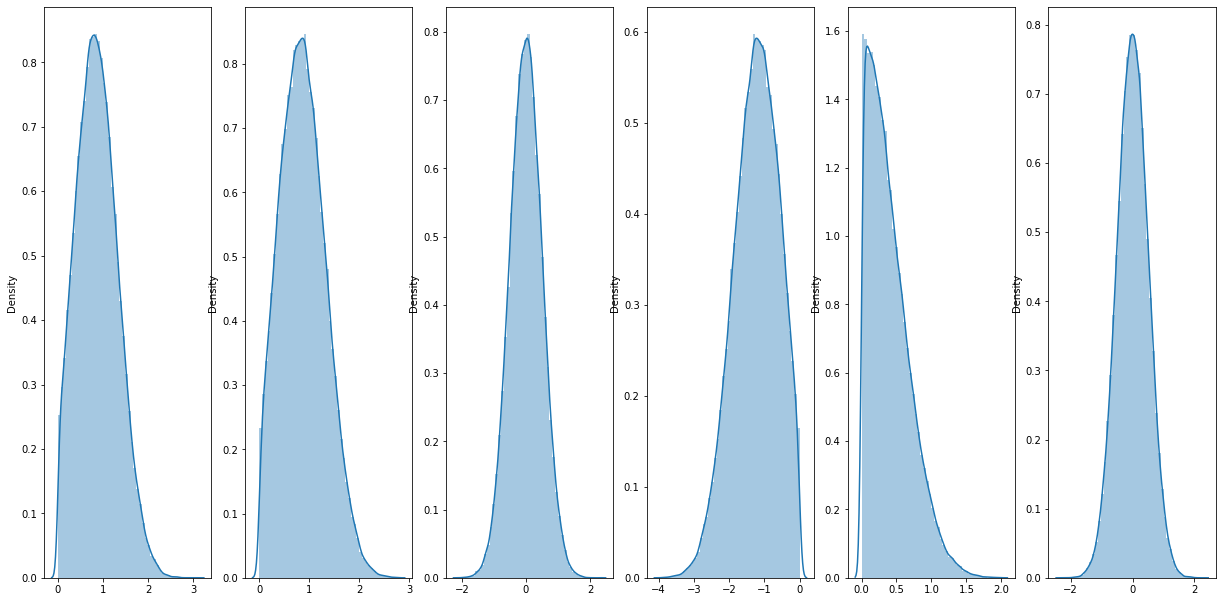

In [152]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns

fig, ax = plt.subplots(1,6)
fig.set_size_inches(21.0, 10.5)

ax[0] = sns.distplot(b_in_scm,ax=ax[0])
ax[1] = sns.distplot(b_in_alt,ax=ax[1])
ax[2] = sns.distplot(b_out_scm,ax=ax[2])
ax[3] = sns.distplot(b_out_alt,ax=ax[3])
ax[4] = sns.distplot(b_both_scm,ax=ax[4])
ax[5] = sns.distplot(b_both_alt,ax=ax[5])